In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer

In [2]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
beta = 1
gamma = 1 
fuzzy_labels = 12 #10 цифр + 2 класса на цифры с кругляшками и без
unknown_classes_ratio = 0.0 # доля неизвестных классов 
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    if (target_label == 0) or (target_label == 6) or (target_label == 8) or (target_label == 9):
        t[0][fuzzy_labels - 2] = 1
    else:
        t[0][fuzzy_labels - 1] = 1
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [9]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [10]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)

        self.fuzzy = nn.Sequential(
            FuzzyLayer.from_dimensions(latent_dim, labels_count, trainable=True)
        )
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        labels = self.fuzzy(mu)

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu)

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [11]:
def keep_eigenvals_positive_loss(d, eps = 1e-3):
    ev = d.fuzzy[0].get_transformation_matrix_eigenvals().real.min()
    ev = torch.where(ev > eps, eps, ev)
    return -ev

In [12]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [13]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,317


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [14]:
# import torchviz
# import os
# os.environ["PATH"] += os.pathsep + 'F:/Users/Yuri/Downloads/windows_10_msbuild_Release_graphviz-7.0.4-win32/Graphviz/bin'


# x = torch.randn(2, 1, 28, 28).to(device)
# torchviz.make_dot(model(x), params=dict(model.named_parameters()))

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [16]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward(retain_graph=True)
        ev_loss = keep_eigenvals_positive_loss(model)
        ev_loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} EV {ev_loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/EV', ev_loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [17]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [18]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 23.8749 EV -0.0010 (Recon: 20.6597, KL: 0.2060 Fuzzy: 3.0092) Grad: 17.8855
Step 100 (N samples: 25,600), Loss: 9.6263 EV -0.0010 (Recon: 7.3662, KL: 0.6322 Fuzzy: 1.6279) Grad: 8.8270
Step 200 (N samples: 51,200), Loss: 8.6057 EV -0.0010 (Recon: 6.7633, KL: 0.6174 Fuzzy: 1.2250) Grad: 6.1149


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.5600 (BCE: 6.8703, KLD: 0.6573 Fuzzy: 1.0324 Accuracy 0.6893)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 8.3798 EV -0.0010 (Recon: 6.7456, KL: 0.6819 Fuzzy: 0.9522) Grad: 5.7779
Step 400 (N samples: 102,400), Loss: 8.0515 EV -0.0010 (Recon: 6.6559, KL: 0.6261 Fuzzy: 0.7694) Grad: 4.4878


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.0596 (BCE: 6.6238, KLD: 0.6715 Fuzzy: 0.7643 Accuracy 0.7582)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 8.1308 EV -0.0010 (Recon: 6.7531, KL: 0.6581 Fuzzy: 0.7196) Grad: 3.5513
Step 600 (N samples: 153,600), Loss: 7.9130 EV -0.0010 (Recon: 6.5059, KL: 0.7509 Fuzzy: 0.6563) Grad: 4.1514
Step 700 (N samples: 179,200), Loss: 7.8271 EV -0.0010 (Recon: 6.4999, KL: 0.7524 Fuzzy: 0.5748) Grad: 4.3817


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.8420 (BCE: 6.5161, KLD: 0.7341 Fuzzy: 0.5919 Accuracy 0.8177)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.6862 EV -0.0010 (Recon: 6.3854, KL: 0.7578 Fuzzy: 0.5430) Grad: 3.0593
Step 900 (N samples: 230,400), Loss: 7.6728 EV -0.0010 (Recon: 6.3817, KL: 0.7567 Fuzzy: 0.5344) Grad: 3.7926


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7280 (BCE: 6.4281, KLD: 0.7879 Fuzzy: 0.5120 Accuracy 0.8345)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.6884 EV -0.0010 (Recon: 6.4966, KL: 0.7394 Fuzzy: 0.4523) Grad: 2.1218
Step 1,100 (N samples: 281,600), Loss: 7.7409 EV -0.0010 (Recon: 6.5030, KL: 0.7403 Fuzzy: 0.4976) Grad: 2.6884


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7018 (BCE: 6.4785, KLD: 0.7551 Fuzzy: 0.4683 Accuracy 0.8437)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.8141 EV -0.0010 (Recon: 6.6018, KL: 0.7203 Fuzzy: 0.4920) Grad: 2.9434
Step 1,300 (N samples: 332,800), Loss: 7.6951 EV -0.0010 (Recon: 6.5204, KL: 0.6983 Fuzzy: 0.4765) Grad: 2.3891
Step 1,400 (N samples: 358,400), Loss: 7.5118 EV -0.0010 (Recon: 6.3480, KL: 0.7298 Fuzzy: 0.4340) Grad: 2.3790


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6464 (BCE: 6.3938, KLD: 0.8144 Fuzzy: 0.4381 Accuracy 0.8636)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.6861 EV -0.0010 (Recon: 6.4435, KL: 0.7971 Fuzzy: 0.4454) Grad: 2.5949
Step 1,600 (N samples: 409,600), Loss: 7.5744 EV -0.0010 (Recon: 6.3503, KL: 0.7868 Fuzzy: 0.4373) Grad: 1.7984


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6485 (BCE: 6.3575, KLD: 0.8577 Fuzzy: 0.4332 Accuracy 0.9158)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.5898 EV -0.0010 (Recon: 6.3632, KL: 0.7994 Fuzzy: 0.4271) Grad: 2.8932
Step 1,800 (N samples: 460,800), Loss: 7.6247 EV -0.0010 (Recon: 6.4815, KL: 0.7650 Fuzzy: 0.3783) Grad: 2.9738


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5190 (BCE: 6.3434, KLD: 0.8116 Fuzzy: 0.3641 Accuracy 0.9384)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.8233 EV -0.0010 (Recon: 6.6244, KL: 0.7950 Fuzzy: 0.4038) Grad: 3.1985
Step 2,000 (N samples: 512,000), Loss: 7.7046 EV -0.0010 (Recon: 6.5223, KL: 0.7702 Fuzzy: 0.4121) Grad: 2.9504
Step 2,100 (N samples: 537,600), Loss: 7.6136 EV -0.0010 (Recon: 6.4378, KL: 0.8063 Fuzzy: 0.3694) Grad: 2.8304


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5230 (BCE: 6.3418, KLD: 0.8298 Fuzzy: 0.3514 Accuracy 0.9502)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.5400 EV -0.0010 (Recon: 6.4101, KL: 0.7858 Fuzzy: 0.3440) Grad: 2.5287
Step 2,300 (N samples: 588,800), Loss: 7.4893 EV -0.0010 (Recon: 6.3646, KL: 0.7673 Fuzzy: 0.3574) Grad: 3.1935


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4953 (BCE: 6.2955, KLD: 0.8581 Fuzzy: 0.3417 Accuracy 0.9533)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.4457 EV -0.0010 (Recon: 6.2588, KL: 0.8400 Fuzzy: 0.3469) Grad: 2.7793
Step 2,500 (N samples: 640,000), Loss: 7.5489 EV -0.0010 (Recon: 6.3953, KL: 0.8036 Fuzzy: 0.3500) Grad: 2.6387


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4586 (BCE: 6.3134, KLD: 0.8279 Fuzzy: 0.3173 Accuracy 0.9563)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.4120 EV -0.0010 (Recon: 6.2760, KL: 0.8018 Fuzzy: 0.3341) Grad: 1.8242
Step 2,700 (N samples: 691,200), Loss: 7.7789 EV -0.0010 (Recon: 6.5345, KL: 0.8375 Fuzzy: 0.4069) Grad: 2.6160
Step 2,800 (N samples: 716,800), Loss: 7.3898 EV -0.0010 (Recon: 6.2191, KL: 0.8075 Fuzzy: 0.3632) Grad: 2.2562


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4768 (BCE: 6.3098, KLD: 0.8418 Fuzzy: 0.3252 Accuracy 0.9559)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.8048 EV -0.0010 (Recon: 6.5770, KL: 0.8117 Fuzzy: 0.4161) Grad: 3.1421
Step 3,000 (N samples: 768,000), Loss: 7.4551 EV -0.0010 (Recon: 6.3315, KL: 0.8168 Fuzzy: 0.3068) Grad: 2.0799


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4534 (BCE: 6.3224, KLD: 0.8328 Fuzzy: 0.2982 Accuracy 0.9584)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.5190 EV -0.0010 (Recon: 6.3647, KL: 0.8210 Fuzzy: 0.3334) Grad: 3.0929
Step 3,200 (N samples: 819,200), Loss: 7.4695 EV -0.0010 (Recon: 6.2987, KL: 0.8201 Fuzzy: 0.3507) Grad: 2.4561


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4135 (BCE: 6.2547, KLD: 0.8633 Fuzzy: 0.2954 Accuracy 0.9603)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.6564 EV -0.0010 (Recon: 6.5076, KL: 0.7831 Fuzzy: 0.3656) Grad: 2.1033
Step 3,400 (N samples: 870,400), Loss: 7.5500 EV -0.0010 (Recon: 6.4236, KL: 0.8151 Fuzzy: 0.3112) Grad: 2.3342
Step 3,500 (N samples: 896,000), Loss: 7.2198 EV -0.0010 (Recon: 6.1165, KL: 0.8435 Fuzzy: 0.2598) Grad: 1.5164


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4223 (BCE: 6.2895, KLD: 0.8376 Fuzzy: 0.2951 Accuracy 0.9618)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.3831 EV -0.0010 (Recon: 6.2716, KL: 0.8372 Fuzzy: 0.2743) Grad: 2.2923
Step 3,700 (N samples: 947,200), Loss: 7.4770 EV -0.0010 (Recon: 6.3040, KL: 0.8202 Fuzzy: 0.3527) Grad: 3.0102


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4392 (BCE: 6.3067, KLD: 0.8260 Fuzzy: 0.3064 Accuracy 0.9628)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.3542 EV -0.0010 (Recon: 6.2100, KL: 0.8179 Fuzzy: 0.3263) Grad: 1.9908
Step 3,900 (N samples: 998,400), Loss: 7.5184 EV -0.0010 (Recon: 6.3812, KL: 0.8265 Fuzzy: 0.3106) Grad: 2.4068


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3891 (BCE: 6.2758, KLD: 0.8303 Fuzzy: 0.2830 Accuracy 0.9634)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.5131 EV -0.0010 (Recon: 6.4140, KL: 0.8020 Fuzzy: 0.2971) Grad: 2.1343
Step 4,100 (N samples: 1,049,600), Loss: 7.3896 EV -0.0010 (Recon: 6.2041, KL: 0.8609 Fuzzy: 0.3246) Grad: 2.5222
Step 4,200 (N samples: 1,075,200), Loss: 7.4188 EV -0.0010 (Recon: 6.2588, KL: 0.8774 Fuzzy: 0.2825) Grad: 1.9255


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4155 (BCE: 6.3028, KLD: 0.8273 Fuzzy: 0.2854 Accuracy 0.9646)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.3956 EV -0.0010 (Recon: 6.2787, KL: 0.8306 Fuzzy: 0.2863) Grad: 2.6082
Step 4,400 (N samples: 1,126,400), Loss: 7.4434 EV -0.0010 (Recon: 6.3288, KL: 0.8250 Fuzzy: 0.2895) Grad: 2.4039


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4153 (BCE: 6.2599, KLD: 0.8648 Fuzzy: 0.2906 Accuracy 0.9651)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.3776 EV -0.0010 (Recon: 6.2187, KL: 0.8265 Fuzzy: 0.3324) Grad: 2.3918
Step 4,600 (N samples: 1,177,600), Loss: 7.3814 EV -0.0010 (Recon: 6.2734, KL: 0.8403 Fuzzy: 0.2677) Grad: 2.2797


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3913 (BCE: 6.2501, KLD: 0.8567 Fuzzy: 0.2845 Accuracy 0.9640)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.6042 EV -0.0010 (Recon: 6.4465, KL: 0.8403 Fuzzy: 0.3175) Grad: 2.3430
Step 4,800 (N samples: 1,228,800), Loss: 7.2162 EV -0.0010 (Recon: 6.1240, KL: 0.8393 Fuzzy: 0.2529) Grad: 1.9409
Step 4,900 (N samples: 1,254,400), Loss: 7.4686 EV -0.0010 (Recon: 6.2542, KL: 0.9026 Fuzzy: 0.3118) Grad: 1.6971


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3796 (BCE: 6.2701, KLD: 0.8374 Fuzzy: 0.2722 Accuracy 0.9645)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.5014 EV -0.0010 (Recon: 6.3117, KL: 0.8330 Fuzzy: 0.3567) Grad: 2.2077
Step 5,100 (N samples: 1,305,600), Loss: 7.3150 EV -0.0010 (Recon: 6.1901, KL: 0.8599 Fuzzy: 0.2649) Grad: 1.9800


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3736 (BCE: 6.2105, KLD: 0.8808 Fuzzy: 0.2822 Accuracy 0.9656)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.6094 EV -0.0010 (Recon: 6.4620, KL: 0.8706 Fuzzy: 0.2769) Grad: 1.7507
Step 5,300 (N samples: 1,356,800), Loss: 7.2577 EV -0.0010 (Recon: 6.1079, KL: 0.8596 Fuzzy: 0.2902) Grad: 1.8288
Step 5,400 (N samples: 1,382,400), Loss: 7.3676 EV -0.0010 (Recon: 6.2484, KL: 0.8407 Fuzzy: 0.2786) Grad: 1.6063


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3833 (BCE: 6.2490, KLD: 0.8567 Fuzzy: 0.2776 Accuracy 0.9688)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 7.5265 EV -0.0010 (Recon: 6.3292, KL: 0.8626 Fuzzy: 0.3347) Grad: 2.5417
Step 5,600 (N samples: 1,433,600), Loss: 7.5379 EV -0.0010 (Recon: 6.3319, KL: 0.8605 Fuzzy: 0.3456) Grad: 2.7995


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3757 (BCE: 6.2562, KLD: 0.8495 Fuzzy: 0.2700 Accuracy 0.9679)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.5455 EV -0.0010 (Recon: 6.4202, KL: 0.8477 Fuzzy: 0.2776) Grad: 1.9543
Step 5,800 (N samples: 1,484,800), Loss: 7.6071 EV -0.0010 (Recon: 6.4574, KL: 0.8583 Fuzzy: 0.2914) Grad: 2.0450


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3761 (BCE: 6.2453, KLD: 0.8599 Fuzzy: 0.2708 Accuracy 0.9668)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.3703 EV -0.0010 (Recon: 6.2467, KL: 0.8320 Fuzzy: 0.2916) Grad: 2.5150
Step 6,000 (N samples: 1,536,000), Loss: 7.4479 EV -0.0010 (Recon: 6.3356, KL: 0.8295 Fuzzy: 0.2828) Grad: 1.7124
Step 6,100 (N samples: 1,561,600), Loss: 7.3422 EV -0.0010 (Recon: 6.1947, KL: 0.8600 Fuzzy: 0.2875) Grad: 1.6883


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3649 (BCE: 6.2244, KLD: 0.8717 Fuzzy: 0.2689 Accuracy 0.9699)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.2356 EV -0.0010 (Recon: 6.1569, KL: 0.8447 Fuzzy: 0.2340) Grad: 1.6231
Step 6,300 (N samples: 1,612,800), Loss: 7.4474 EV -0.0010 (Recon: 6.3258, KL: 0.8527 Fuzzy: 0.2689) Grad: 1.5757


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4021 (BCE: 6.2282, KLD: 0.8993 Fuzzy: 0.2745 Accuracy 0.9680)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.2523 EV -0.0010 (Recon: 6.1560, KL: 0.8315 Fuzzy: 0.2648) Grad: 1.7712
Step 6,500 (N samples: 1,664,000), Loss: 7.4609 EV -0.0010 (Recon: 6.3035, KL: 0.8716 Fuzzy: 0.2858) Grad: 2.0175


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3690 (BCE: 6.2194, KLD: 0.8775 Fuzzy: 0.2721 Accuracy 0.9703)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.4844 EV -0.0010 (Recon: 6.3255, KL: 0.8655 Fuzzy: 0.2934) Grad: 2.3647
Step 6,700 (N samples: 1,715,200), Loss: 7.4590 EV -0.0010 (Recon: 6.2598, KL: 0.8831 Fuzzy: 0.3161) Grad: 2.1334
Step 6,800 (N samples: 1,740,800), Loss: 7.2310 EV -0.0010 (Recon: 6.1327, KL: 0.8328 Fuzzy: 0.2654) Grad: 2.2988


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3647 (BCE: 6.2262, KLD: 0.8758 Fuzzy: 0.2628 Accuracy 0.9705)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.6985 EV -0.0010 (Recon: 6.4919, KL: 0.8706 Fuzzy: 0.3361) Grad: 2.3204
Step 7,000 (N samples: 1,792,000), Loss: 7.5798 EV -0.0010 (Recon: 6.4194, KL: 0.8291 Fuzzy: 0.3313) Grad: 2.7518


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3685 (BCE: 6.2185, KLD: 0.8793 Fuzzy: 0.2707 Accuracy 0.9693)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.4575 EV -0.0010 (Recon: 6.3009, KL: 0.8529 Fuzzy: 0.3037) Grad: 1.5666
Step 7,200 (N samples: 1,843,200), Loss: 7.4421 EV -0.0010 (Recon: 6.3304, KL: 0.8544 Fuzzy: 0.2574) Grad: 2.6061


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3512 (BCE: 6.2367, KLD: 0.8519 Fuzzy: 0.2626 Accuracy 0.9717)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.5106 EV -0.0010 (Recon: 6.4312, KL: 0.8515 Fuzzy: 0.2279) Grad: 2.3627
Step 7,400 (N samples: 1,894,400), Loss: 7.3781 EV -0.0010 (Recon: 6.2478, KL: 0.8802 Fuzzy: 0.2501) Grad: 1.3002
Step 7,500 (N samples: 1,920,000), Loss: 7.4780 EV -0.0010 (Recon: 6.3925, KL: 0.8464 Fuzzy: 0.2391) Grad: 1.9816


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3439 (BCE: 6.2140, KLD: 0.8665 Fuzzy: 0.2634 Accuracy 0.9707)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.4117 EV -0.0010 (Recon: 6.2871, KL: 0.8638 Fuzzy: 0.2609) Grad: 1.5639
Step 7,700 (N samples: 1,971,200), Loss: 7.3666 EV -0.0010 (Recon: 6.1952, KL: 0.8891 Fuzzy: 0.2823) Grad: 1.5340


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3388 (BCE: 6.2131, KLD: 0.8646 Fuzzy: 0.2611 Accuracy 0.9705)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 7.2853 EV -0.0010 (Recon: 6.1296, KL: 0.8697 Fuzzy: 0.2860) Grad: 2.1149
Step 7,900 (N samples: 2,022,400), Loss: 7.5776 EV -0.0010 (Recon: 6.3479, KL: 0.8959 Fuzzy: 0.3338) Grad: 2.4081


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3541 (BCE: 6.1935, KLD: 0.9028 Fuzzy: 0.2578 Accuracy 0.9726)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 7.4067 EV -0.0010 (Recon: 6.2737, KL: 0.8772 Fuzzy: 0.2558) Grad: 1.6002
Step 8,100 (N samples: 2,073,600), Loss: 7.4181 EV -0.0010 (Recon: 6.2313, KL: 0.8987 Fuzzy: 0.2881) Grad: 2.0858
Step 8,200 (N samples: 2,099,200), Loss: 7.3395 EV -0.0010 (Recon: 6.2287, KL: 0.8770 Fuzzy: 0.2338) Grad: 1.5924


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3704 (BCE: 6.2122, KLD: 0.8906 Fuzzy: 0.2676 Accuracy 0.9687)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 7.3627 EV -0.0010 (Recon: 6.2129, KL: 0.8705 Fuzzy: 0.2793) Grad: 1.4956
Step 8,400 (N samples: 2,150,400), Loss: 7.4761 EV -0.0010 (Recon: 6.2805, KL: 0.9155 Fuzzy: 0.2801) Grad: 1.8448


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3558 (BCE: 6.2143, KLD: 0.8825 Fuzzy: 0.2590 Accuracy 0.9707)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.3948 EV -0.0010 (Recon: 6.2361, KL: 0.8709 Fuzzy: 0.2878) Grad: 2.2229
Step 8,600 (N samples: 2,201,600), Loss: 7.3811 EV -0.0010 (Recon: 6.2251, KL: 0.8663 Fuzzy: 0.2897) Grad: 2.1053


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3516 (BCE: 6.2148, KLD: 0.8753 Fuzzy: 0.2616 Accuracy 0.9697)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.3037 EV -0.0010 (Recon: 6.1860, KL: 0.8497 Fuzzy: 0.2680) Grad: 1.3509
Step 8,800 (N samples: 2,252,800), Loss: 7.4679 EV -0.0010 (Recon: 6.3154, KL: 0.8525 Fuzzy: 0.3000) Grad: 2.7470
Step 8,900 (N samples: 2,278,400), Loss: 7.5173 EV -0.0010 (Recon: 6.3676, KL: 0.8905 Fuzzy: 0.2592) Grad: 1.5700


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3625 (BCE: 6.2009, KLD: 0.8935 Fuzzy: 0.2681 Accuracy 0.9712)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 7.2798 EV -0.0010 (Recon: 6.1453, KL: 0.8956 Fuzzy: 0.2389) Grad: 1.9359
Step 9,100 (N samples: 2,329,600), Loss: 7.5022 EV -0.0010 (Recon: 6.3423, KL: 0.8798 Fuzzy: 0.2800) Grad: 2.2587


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3725 (BCE: 6.2249, KLD: 0.8703 Fuzzy: 0.2773 Accuracy 0.9719)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 7.4505 EV -0.0010 (Recon: 6.3403, KL: 0.8680 Fuzzy: 0.2422) Grad: 1.9257
Step 9,300 (N samples: 2,380,800), Loss: 7.3151 EV -0.0010 (Recon: 6.1773, KL: 0.9022 Fuzzy: 0.2356) Grad: 2.0325


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3512 (BCE: 6.1999, KLD: 0.8858 Fuzzy: 0.2656 Accuracy 0.9700)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 7.5835 EV -0.0010 (Recon: 6.4153, KL: 0.8740 Fuzzy: 0.2943) Grad: 2.5090
Step 9,500 (N samples: 2,432,000), Loss: 7.4943 EV -0.0010 (Recon: 6.3077, KL: 0.8866 Fuzzy: 0.3000) Grad: 2.8007
Step 9,600 (N samples: 2,457,600), Loss: 7.2186 EV -0.0010 (Recon: 6.0734, KL: 0.9062 Fuzzy: 0.2389) Grad: 1.5609


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3489 (BCE: 6.1984, KLD: 0.8872 Fuzzy: 0.2632 Accuracy 0.9722)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.5758 EV -0.0010 (Recon: 6.4321, KL: 0.8879 Fuzzy: 0.2558) Grad: 2.2525
Step 9,800 (N samples: 2,508,800), Loss: 7.3239 EV -0.0010 (Recon: 6.1778, KL: 0.8847 Fuzzy: 0.2614) Grad: 1.7858


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3571 (BCE: 6.2085, KLD: 0.8900 Fuzzy: 0.2585 Accuracy 0.9697)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.3777 EV -0.0010 (Recon: 6.2321, KL: 0.9055 Fuzzy: 0.2401) Grad: 1.8790
Step 10,000 (N samples: 2,560,000), Loss: 7.3726 EV -0.0010 (Recon: 6.1697, KL: 0.9308 Fuzzy: 0.2721) Grad: 1.5657
Step 10,100 (N samples: 2,585,600), Loss: 7.3047 EV -0.0010 (Recon: 6.1607, KL: 0.9022 Fuzzy: 0.2418) Grad: 2.1509


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3246 (BCE: 6.1826, KLD: 0.8886 Fuzzy: 0.2534 Accuracy 0.9729)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.4127 EV -0.0010 (Recon: 6.2001, KL: 0.8856 Fuzzy: 0.3270) Grad: 2.6097
Step 10,300 (N samples: 2,636,800), Loss: 7.3329 EV -0.0010 (Recon: 6.1617, KL: 0.8909 Fuzzy: 0.2803) Grad: 1.7881


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3276 (BCE: 6.1764, KLD: 0.8942 Fuzzy: 0.2569 Accuracy 0.9740)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 7.3516 EV -0.0010 (Recon: 6.2182, KL: 0.8909 Fuzzy: 0.2425) Grad: 1.8040
Step 10,500 (N samples: 2,688,000), Loss: 7.3084 EV -0.0010 (Recon: 6.1834, KL: 0.8772 Fuzzy: 0.2478) Grad: 1.6964


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3337 (BCE: 6.1816, KLD: 0.9005 Fuzzy: 0.2516 Accuracy 0.9720)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 7.4011 EV -0.0010 (Recon: 6.2485, KL: 0.9001 Fuzzy: 0.2524) Grad: 1.5857
Step 10,700 (N samples: 2,739,200), Loss: 7.5769 EV -0.0010 (Recon: 6.3655, KL: 0.8995 Fuzzy: 0.3119) Grad: 2.5648
Step 10,800 (N samples: 2,764,800), Loss: 7.5733 EV -0.0010 (Recon: 6.4153, KL: 0.8964 Fuzzy: 0.2616) Grad: 1.5358


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3340 (BCE: 6.1854, KLD: 0.8997 Fuzzy: 0.2489 Accuracy 0.9723)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.5722 EV -0.0010 (Recon: 6.3720, KL: 0.8734 Fuzzy: 0.3267) Grad: 2.1754
Step 11,000 (N samples: 2,816,000), Loss: 7.4098 EV -0.0010 (Recon: 6.2742, KL: 0.8891 Fuzzy: 0.2465) Grad: 2.3087


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3315 (BCE: 6.1608, KLD: 0.9119 Fuzzy: 0.2587 Accuracy 0.9740)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 7.2266 EV -0.0010 (Recon: 6.0811, KL: 0.8754 Fuzzy: 0.2702) Grad: 2.3758
Step 11,200 (N samples: 2,867,200), Loss: 7.5155 EV -0.0010 (Recon: 6.3238, KL: 0.9288 Fuzzy: 0.2629) Grad: 1.4927


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3291 (BCE: 6.1822, KLD: 0.8921 Fuzzy: 0.2548 Accuracy 0.9728)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.2206 EV -0.0010 (Recon: 6.0203, KL: 0.9183 Fuzzy: 0.2820) Grad: 1.3375
Step 11,400 (N samples: 2,918,400), Loss: 7.2192 EV -0.0010 (Recon: 6.0597, KL: 0.9181 Fuzzy: 0.2413) Grad: 1.7143
Step 11,500 (N samples: 2,944,000), Loss: 7.4060 EV -0.0010 (Recon: 6.2280, KL: 0.9218 Fuzzy: 0.2561) Grad: 2.0970


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3509 (BCE: 6.1934, KLD: 0.8965 Fuzzy: 0.2610 Accuracy 0.9699)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 7.4187 EV -0.0010 (Recon: 6.2697, KL: 0.8769 Fuzzy: 0.2721) Grad: 2.6905
Step 11,700 (N samples: 2,995,200), Loss: 7.4094 EV -0.0010 (Recon: 6.2313, KL: 0.9097 Fuzzy: 0.2685) Grad: 1.6474


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3322 (BCE: 6.1746, KLD: 0.9033 Fuzzy: 0.2544 Accuracy 0.9726)


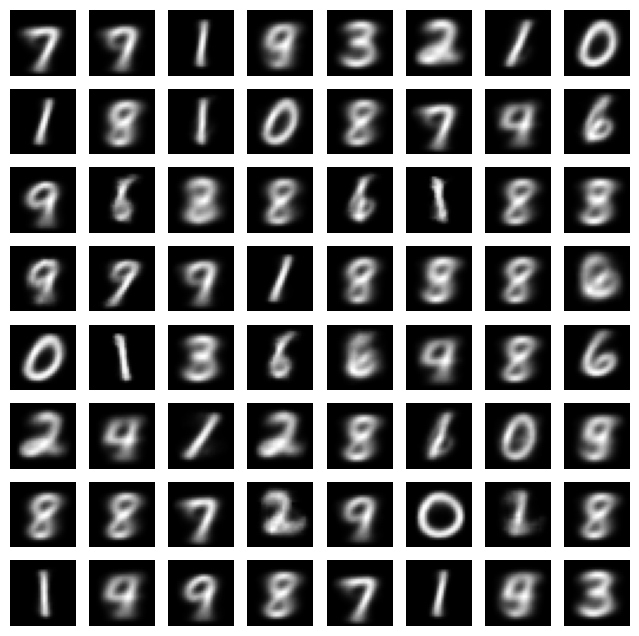

In [19]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [20]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
pred_circ_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_circ_all.append(np.argmax(labels[:, (fuzzy_labels-2):].cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [21]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)
pred_circ_all = np.concatenate(pred_circ_all, axis=0)

In [22]:
np.sum(y_all==pred_y_all)/len(y_all)

0.9719

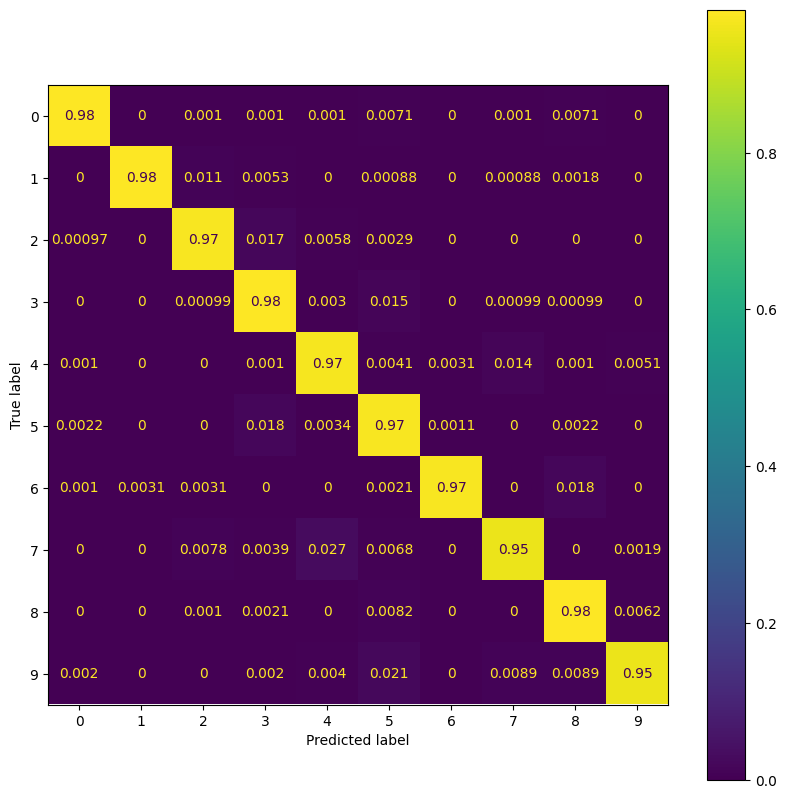

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

(-2.0, 2.0)

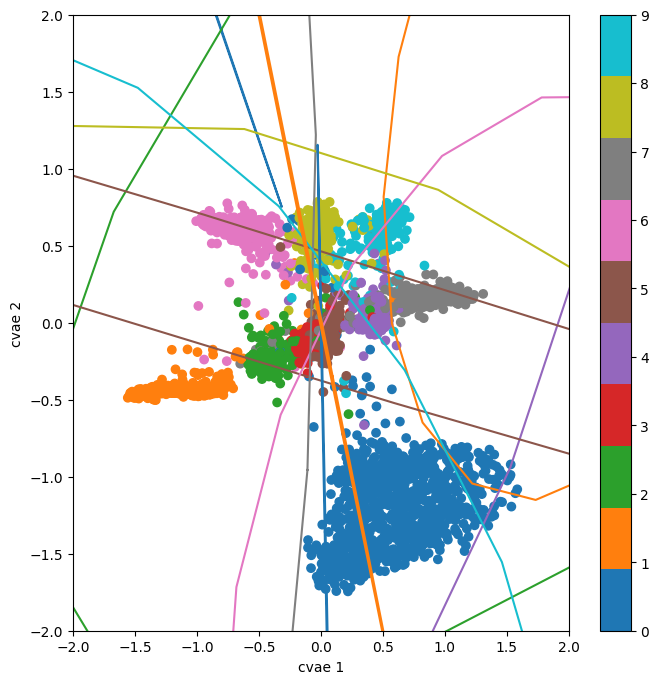

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")
A = model.fuzzy[0].get_transformation_matrix().detach().cpu().numpy()

theta = np.linspace(0, 2*np.pi, 20)
a, b = 1 * np.cos(theta), 1 * np.sin(theta)

for i in range(A.shape[0]):
    h = A[i]
    t = [np.matmul(h, [x[0], x[1], 1]) for x in zip(a,b)]
    t = np.array(t)
    plt.plot(t[:, 0], t[:, 1])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
# plt.show()
#plt.savefig('habr/mnist_2d_scatter_origin_labels_cvae.webp')

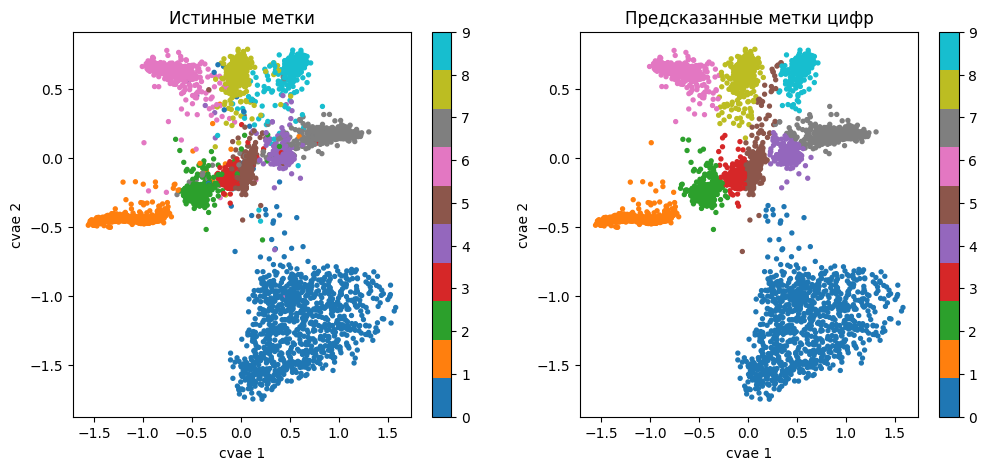

In [30]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
axis[0].set_title("Истинные метки")
axis[0].set_xlabel("cvae 1")
axis[0].set_ylabel("cvae 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10', s=8)
axis[1].set_title("Предсказанные метки цифр") 
axis[1].set_xlabel("cvae 1")
axis[1].set_ylabel("cvae 2")
# sc3 = axis[2].scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='spring')
# axis[2].set_title("Предсказанные метки очертаний") 
# axis[2].set_xlabel("cvae 1")
# axis[2].set_ylabel("cvae 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
#figure.colorbar(sc3)
plt.show()

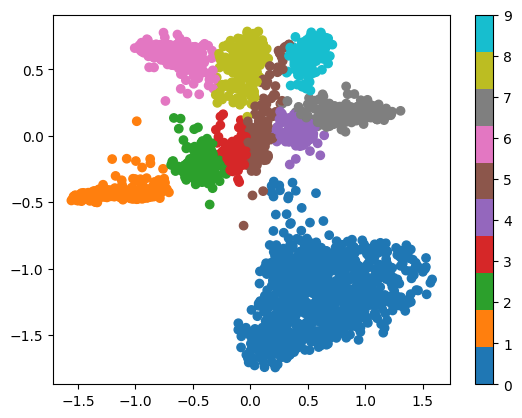

In [31]:

plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_labels.webp')

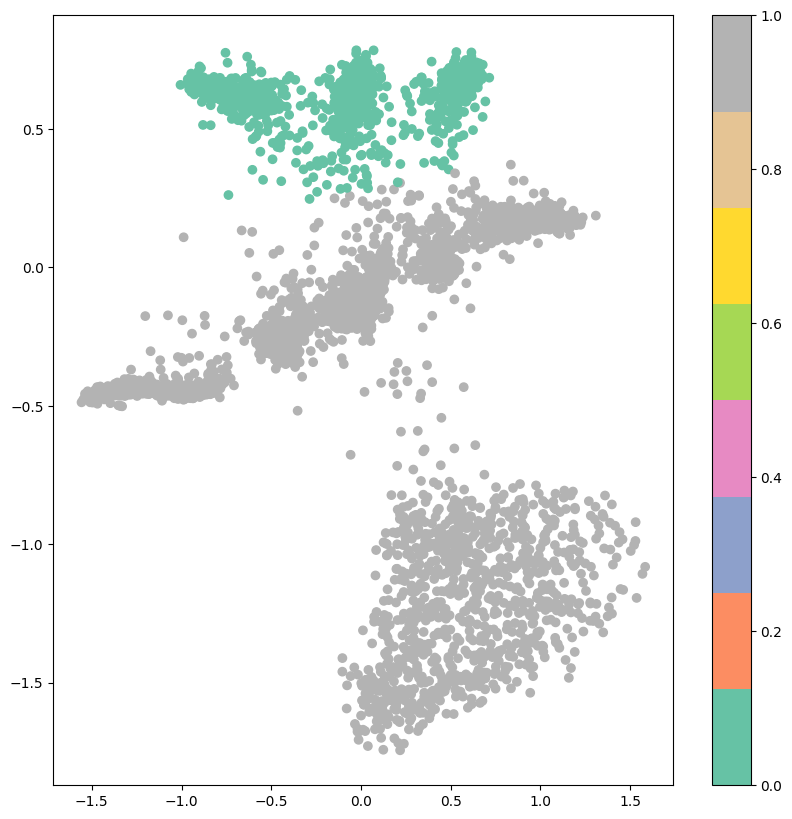

In [32]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='Set2')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_circles.webp')

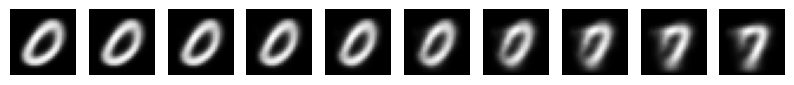

In [34]:
n = 10
z2 = torch.linspace(-1, -0.5, n)
z1 = torch.zeros_like(z2) + 1

z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('cvae_mnist_interp.webp')